In [12]:
import pandas as pd
from utils.data_loader import DataLoader
from utils.kmeans import ClusterEvaluator
import matplotlib.pyplot as plt
from utils.cluster_postprocess import ClusterPostProcessor
from utils.visualisation import plot_wordcloud_for_cluster
from utils.HDBSCAN import HDBSCANClusterer
from utils.feature_enginering import FeatureEngineering
from utils.dimention_reduction import reduce_dimensions_umap
from sentence_transformers import SentenceTransformer
from utils.LDA import LDAProcessor
from glob import glob
from utils.fragmentation_cal import TopicFragmentation
from utils.visualisation import plot_cluster_hdbcsan
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")

# Explotary Data Analysis (EDA)

In [2]:
dataset = ['scrapper/raw_data/debat_tv_one.csv',
        'scrapper/raw_data/ijasah_ditunjukan.csv',
        'scrapper/raw_data/komentar_pihak_yang_dituduh.csv',
        'scrapper/raw_data/komentar_tokoh_politik.csv',
        'scrapper/raw_data/teman_kuliah.csv'
        ]

loader = DataLoader(dataset)
df_all = df_all = loader.load_data(merge=True)
df_all = df_all.dropna()

In [3]:
print(f"Total comments: {len(df_all)}")
print(f"------------------------------------------------------")
print(f"Unique authors: {df_all['author'].nunique()}")
print(f"------------------------------------------------------")
print(f"Info: {df_all.info()}")

Total comments: 71728
------------------------------------------------------
Unique authors: 56754
------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 71728 entries, 0 to 71738
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   author        71728 non-null  object
 1   text          71728 non-null  object
 2   published_at  71728 non-null  object
 3   like_count    71728 non-null  int64 
 4   source        71728 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.3+ MB
Info: None



**Engineered Feature Descriptions**

| Column Name          | Description                                                                                                                                                                                                                                                                           |
| -------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `total_sources`      | The number of unique sources (e.g., videos or threads) in which the author has posted comments. It indicates how widely a user engages across different content.                                                                                                                      |
| `total_comments`     | The total number of comments written by the author in the dataset. This reflects the overall activity level of the user.                                                                                                                                                              |
| `screening_time_min` | The time span in **minutes** between the author's first and last comment. This feature captures the duration of user activity over time.                                                                                                                                              |
| `source_entropy`     | A measure of how evenly a user's comments are distributed across different sources. A **low entropy** means the user is focused on one or two sources, while a **high entropy** indicates comments are spread more evenly — possibly signaling coordinated or campaign-like behavior. |


In [4]:
feature_engineering = FeatureEngineering(df_all)
df_all = feature_engineering.add_features()

In [5]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71728 entries, 0 to 71727
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   author              71728 non-null  object             
 1   text                71728 non-null  object             
 2   published_at        71728 non-null  datetime64[ns, UTC]
 3   like_count          71728 non-null  int64              
 4   source              71728 non-null  object             
 5   total_sources       71728 non-null  int64              
 6   total_comments      71728 non-null  int64              
 7   screening_time_min  71728 non-null  float64            
 8   source_entropy      71728 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(3)
memory usage: 4.9+ MB


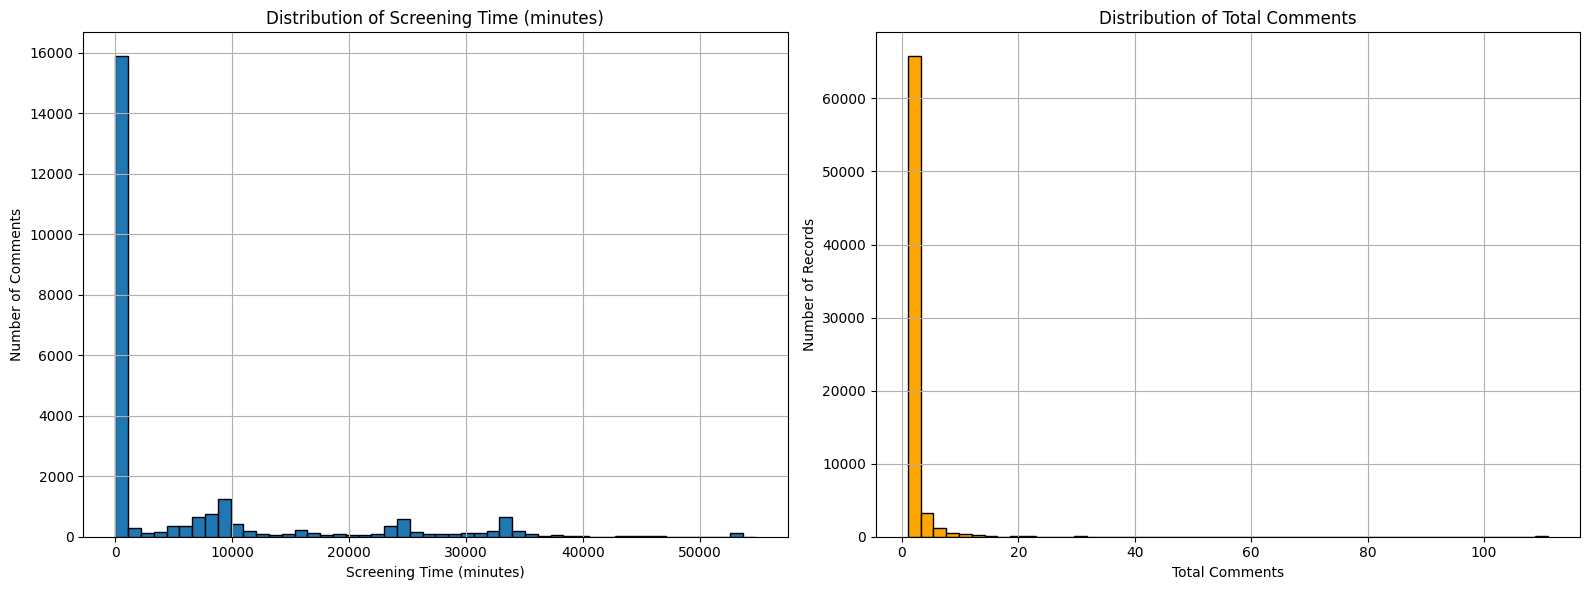

In [6]:
# Filter valid values
screening_data = df_all[df_all['screening_time_min'] > 0]['screening_time_min']
comment_data = df_all[df_all['total_comments'] > 0]['total_comments']

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Histogram for screening time
axs[0].hist(screening_data, bins=50, edgecolor='black')
axs[0].set_title('Distribution of Screening Time (minutes)')
axs[0].set_xlabel('Screening Time (minutes)')
axs[0].set_ylabel('Number of Comments')
axs[0].grid(True)

# Histogram for total comments
axs[1].hist(comment_data, bins=50, edgecolor='black', color='orange')
axs[1].set_title('Distribution of Total Comments')
axs[1].set_xlabel('Total Comments')
axs[1].set_ylabel('Number of Records')
axs[1].grid(True)

plt.tight_layout()
plt.show()

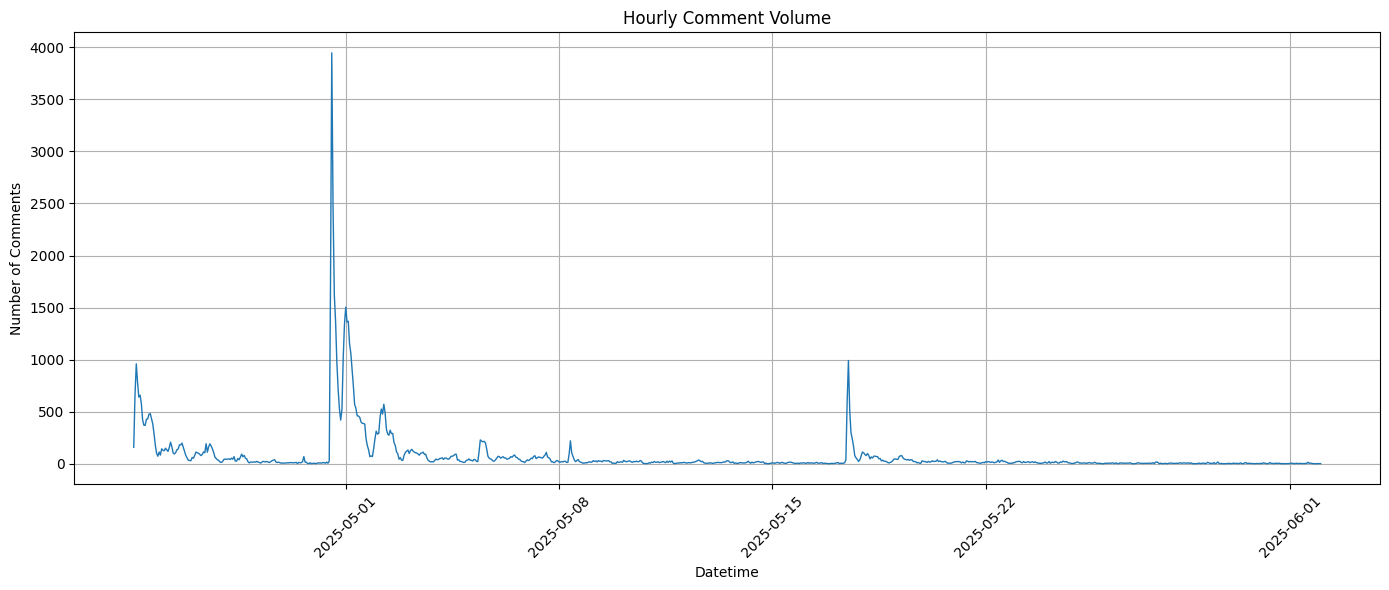

In [7]:
comments_per_hour = df_all['published_at'].dt.floor('h').value_counts().sort_index()

plt.figure(figsize=(14, 6))
plt.plot(comments_per_hour.index, comments_per_hour.values, linewidth=1)
plt.title('Hourly Comment Volume')
plt.xlabel('Datetime')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


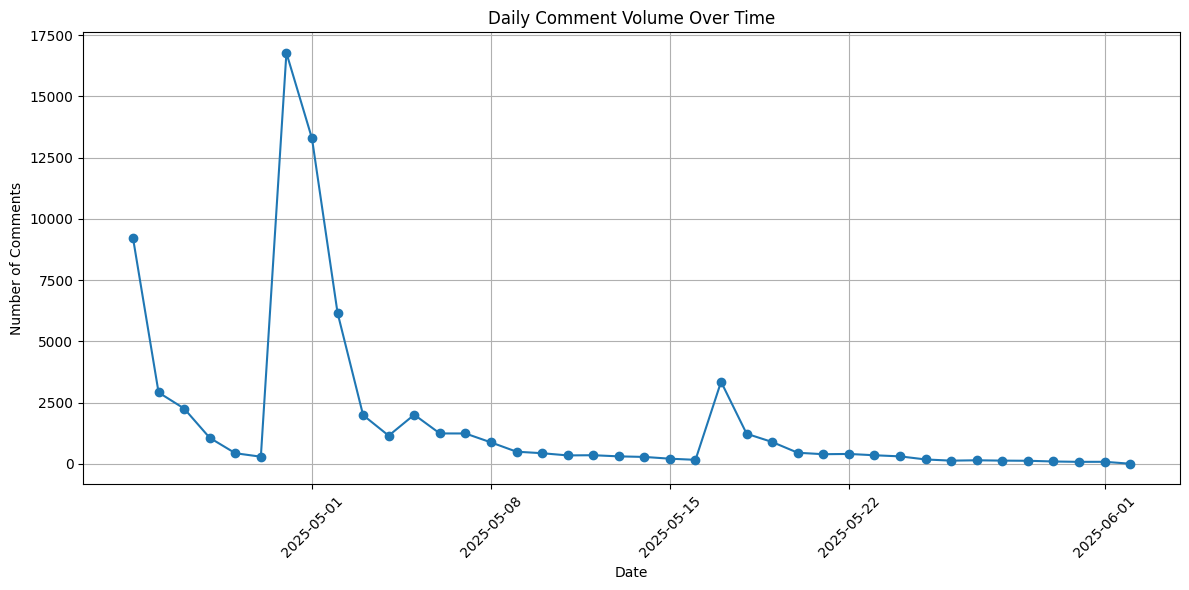

In [8]:
df_all['published_at'] = pd.to_datetime(df_all['published_at'])

comments_per_day = df_all['published_at'].dt.date.value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.plot(comments_per_day.index, comments_per_day.values, marker='o')
plt.title('Daily Comment Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
suspicious_authors_df = df_all[
    (df_all['screening_time_min'] > 0) &
    (df_all['total_sources'] > 1)
]

num_suspicious_authors = suspicious_authors_df['author'].nunique()

print(f"Jumlah author mencurigakan (multi-source + aktif lama): {num_suspicious_authors}")

Jumlah author mencurigakan (multi-source + aktif lama): 2961


In [10]:
df_all = loader.data_preprocessor(df_all, text_col='text')
train_df, val_df, test_df = loader.data_splitter(df_all, text_col='text', test_size=0.1, val_size=0.2)

Train set: 50209 rows
Validation set: 14346 rows
Test set: 7173 rows


In [11]:
model = SentenceTransformer('firqaaa/indo-sentence-bert-base')
train = model.encode(train_df['text'].tolist(), show_progress_bar=True)
val = model.encode(val_df['text'].tolist(), show_progress_bar=True)
test = model.encode(test_df['text'].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 225/225 [00:20<00:00, 10.91it/s]


In [12]:
train = reduce_dimensions_umap(train, metric='cosine')
val = reduce_dimensions_umap(val, metric='cosine')
test = reduce_dimensions_umap(test, metric='cosine')

# KMeans Clustering

In [13]:
training_playground = {
    'Train': train,
    'Validation': val,
    'Test': test
}

cluster_range = range(2, 100, 5)
results = {}

for name, data in training_playground.items():
    evaluator = ClusterEvaluator(data, cluster_range)
    silhouettes = []
    inertias = []
    for result in evaluator.evaluate_kmeans():
        silhouettes.append(result['silhouette_score'])
        inertias.append(result['inertia'])
    results[name] = {
        'silhouette': silhouettes,
        'inertia': inertias
    }

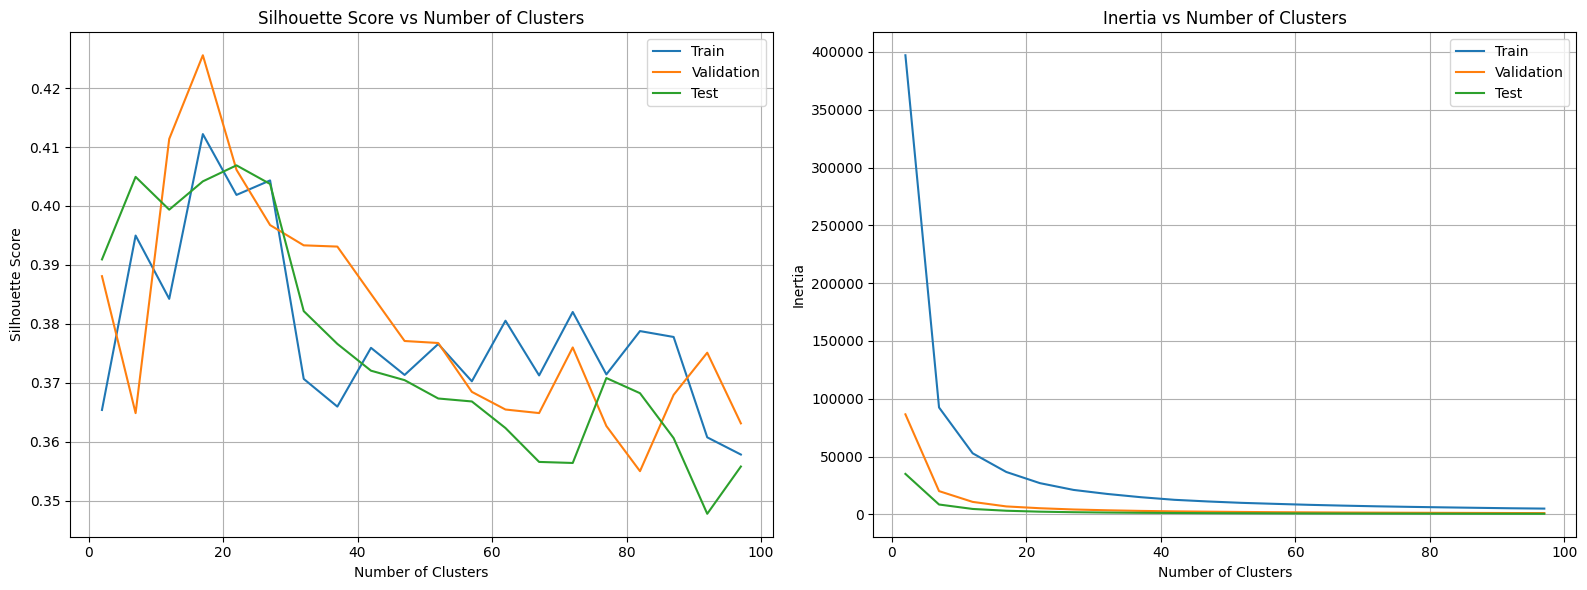

In [14]:
cluster_list = list(cluster_range)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
for name in results:
    axs[0].plot(cluster_list, results[name]['silhouette'], label=name)
axs[0].set_title('Silhouette Score vs Number of Clusters')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')
axs[0].grid(True)
axs[0].legend()
for name in results:
    axs[1].plot(cluster_list, results[name]['inertia'], label=name)
axs[1].set_title('Inertia vs Number of Clusters')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Inertia')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()


Although the silhouette score peaked at k=17 , we selected k=15 as an optimal trade-off between model performance and thematic interpretability. Given that the clustering was performed using a step size of 5 (i.e., evaluating k=2,7,12,17,... ), it is likely that k=15 would have achieved performance close to the peak while avoiding excessive fragmentation. Furthermore, manual inspection of the topics revealed that increasing k beyond 15 led to diminishing returns in terms of thematic clarity, with several clusters showing overlapping or redundant themes. Therefore, k=15 was chosen as a balanced solution that preserves meaningful variation without introducing unnecessary complexity.

In [15]:
processor = ClusterPostProcessor(best_k=15, df=df_all, output_dir='clusters/kmeans')
clusters = processor.run()

Batches: 100%|██████████| 2242/2242 [03:15<00:00, 11.49it/s]


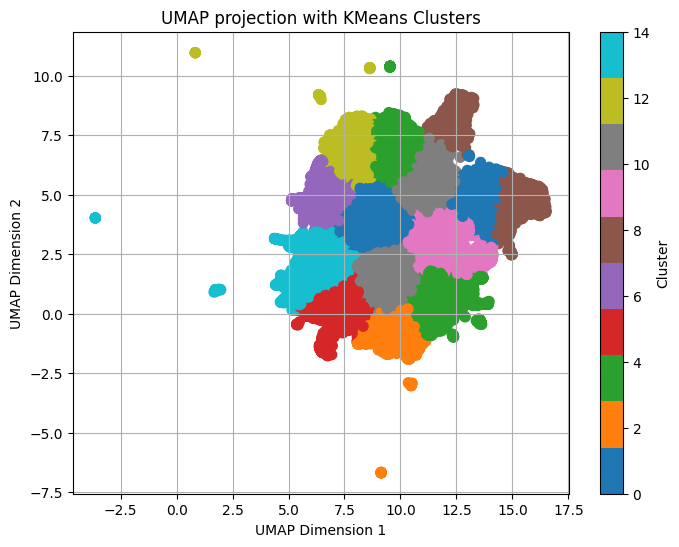

In [16]:
processor.plot_clusters()

# LDA

In [4]:
text_column = 'text'
num_topics = 5
passes = 10
workers = 2
results = []

for i, file_path in enumerate(glob('clusters/kmeans/*')):
    df = pd.read_csv(file_path)
    print(f"\nProcessing DataFrame #{i+1} from file: {file_path}")
    lda = LDAProcessor(df, text_column=text_column, num_topics=num_topics, passes=passes, workers=workers)
    processed_texts = lda.prepare_corpus()
    lda.train_lda()
    topics = lda.lda_model.print_topics(num_words=5)
    topics_str = "\n".join([f"Topic #{idx}: {topic}" for idx, topic in topics])
    coherence = lda.compute_coherence(processed_texts)
    print(f"Coherence Score: {coherence:.4f}")
    
    results.append({
        'file': file_path,
        'coherence': coherence,
        'topics': topics_str
    })

results_df = pd.DataFrame(results)
print(results_df)


Processing DataFrame #1 from file: clusters/kmeans/cluster_0.csv
Coherence Score: 0.3621

Processing DataFrame #2 from file: clusters/kmeans/cluster_5.csv
Coherence Score: 0.3943

Processing DataFrame #3 from file: clusters/kmeans/cluster_1.csv
Coherence Score: 0.3786

Processing DataFrame #4 from file: clusters/kmeans/cluster_11.csv
Coherence Score: 0.3207

Processing DataFrame #5 from file: clusters/kmeans/cluster_4.csv
Coherence Score: 0.2851

Processing DataFrame #6 from file: clusters/kmeans/cluster_3.csv
Coherence Score: 0.3086

Processing DataFrame #7 from file: clusters/kmeans/cluster_8.csv
Coherence Score: 0.3546

Processing DataFrame #8 from file: clusters/kmeans/cluster_9.csv
Coherence Score: 0.3566

Processing DataFrame #9 from file: clusters/kmeans/cluster_10.csv
Coherence Score: 0.3413

Processing DataFrame #10 from file: clusters/kmeans/cluster_7.csv
Coherence Score: 0.3843

Processing DataFrame #11 from file: clusters/kmeans/cluster_2.csv
Coherence Score: 0.3350

Proce

In [5]:
results_df.to_csv('lda_results.csv', index=False)

Fragmentation Score: 0.2019597931399173


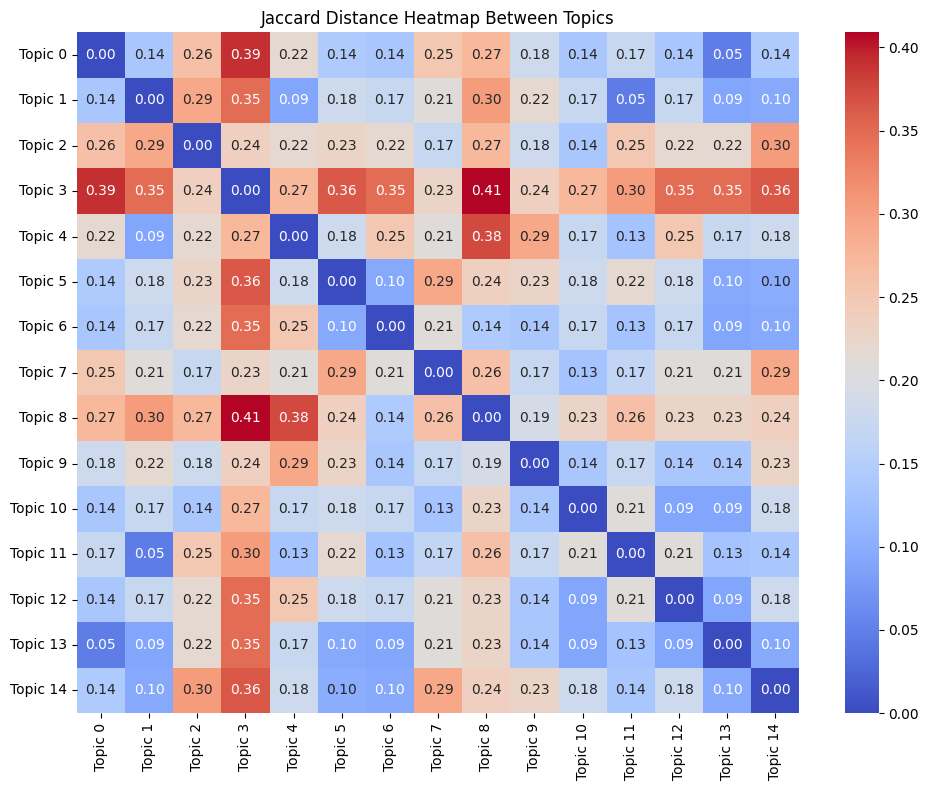

In [2]:
df = pd.read_csv('lda_results.csv')
tf = TopicFragmentation(df, topic_column='topics')
print("Fragmentation Score:", tf.calculate_fragmentation())
tf.plot_jaccard_heatmap()

The Jaccard distance heatmap reveals the degree of lexical overlap and divergence between topics extracted using LDA, providing insight into the structure and fragmentation of online discourse . Notably, Topic 3 and Topic 8 exhibit a relatively high Jaccard distance of 0.41 , indicating that they discuss distinct political narratives : Topic 3 primarily revolves around Roy Suryo, legal issues, and symbolic satire (e.g., "panci") , while Topic 8 centers on negative sentiment toward Jokowi with words like "benci" and "rakyat". Despite some minor overlaps — such as occasional mentions of Jokowi within Topic 3 — the dominant themes remain separate, supporting the presence of differentiated discussion groups in the dataset. Meanwhile, several other topic pairs show very low Jaccard distance (e.g., 0.00) , suggesting redundancy or thematic similarity , and potentially justifying their consolidation. Overall, the heatmap illustrates that while some topics are clearly distinct , others share considerable lexical overlap, reflecting both polarization and fragmentation in public opinion expressed through social media comments.

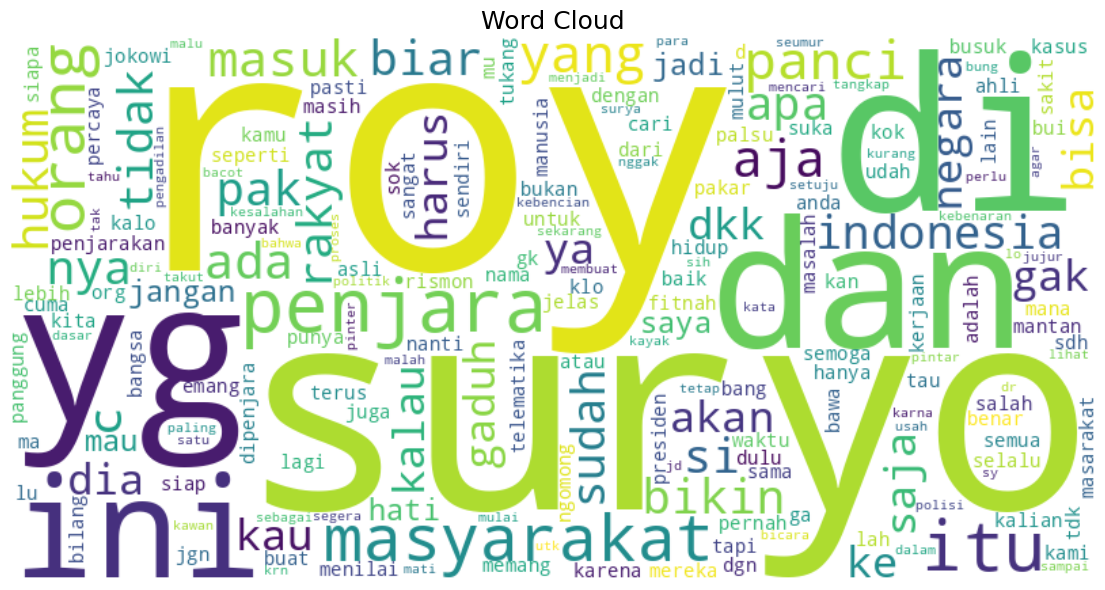

In [21]:
cluster_3 = pd.read_csv('clusters/kmeans/cluster_3.csv')
plot_wordcloud_for_cluster(cluster_3)

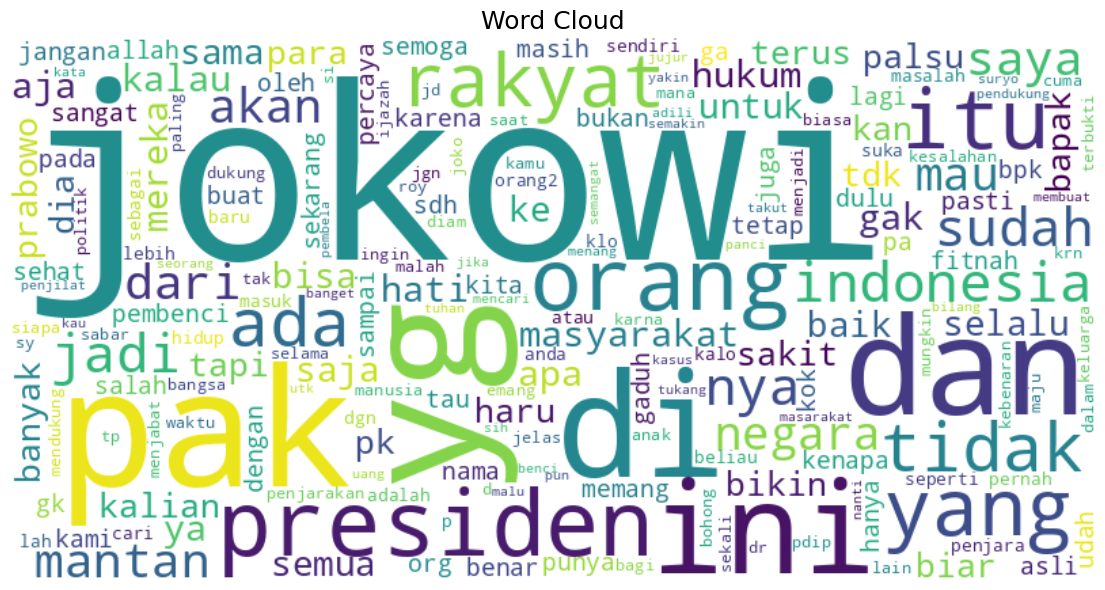

In [22]:
cluster_8 = pd.read_csv('clusters/kmeans/cluster_8.csv')
plot_wordcloud_for_cluster(cluster_8)

# HBDSCAN Clustering


In [13]:
df = df_all.copy()
df.drop(columns=['author','text', 'published_at','source'], inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71728 entries, 0 to 71727
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   like_count          71728 non-null  int64  
 1   total_sources       71728 non-null  int64  
 2   total_comments      71728 non-null  int64  
 3   screening_time_min  71728 non-null  float64
 4   source_entropy      71728 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 2.7 MB


In [15]:
data = df.values
clusterer = HDBSCANClusterer()
best_params = clusterer.hyperparameter_search(
    data,
    min_cluster_sizes=[5, 10, 20],
    min_samples_list=[1, 5, 10]
)
print("Best hyperparameters:", best_params)

min_cluster_size=5, min_samples=1 => 6 clusters, 0 noise points
min_cluster_size=5, min_samples=5 => 6 clusters, 0 noise points
min_cluster_size=5, min_samples=10 => 6 clusters, 0 noise points
min_cluster_size=10, min_samples=1 => 6 clusters, 0 noise points
min_cluster_size=10, min_samples=5 => 6 clusters, 0 noise points
min_cluster_size=10, min_samples=10 => 6 clusters, 0 noise points
min_cluster_size=20, min_samples=1 => 6 clusters, 0 noise points
min_cluster_size=20, min_samples=5 => 6 clusters, 0 noise points
min_cluster_size=20, min_samples=10 => 6 clusters, 0 noise points

Best Parameters: {'min_cluster_size': 5, 'min_samples': 1, 'n_clusters': 6, 'n_noise': 0}
Best hyperparameters: {'min_cluster_size': 5, 'min_samples': 1, 'n_clusters': 6, 'n_noise': 0}


In [16]:
clusterers = HDBSCANClusterer(min_cluster_size=best_params['min_cluster_size'], min_samples=best_params['min_samples'])
clusters = clusterers.fit(data)
results = clusterers.evaluate()

Number of clusters: 6
Number of noise points: 0
Cluster sizes:
  Cluster 0: 43243 points
  Cluster 1: 15275 points
  Cluster 2: 4011 points
  Cluster 3: 6926 points
  Cluster 4: 1365 points
  Cluster 5: 908 points


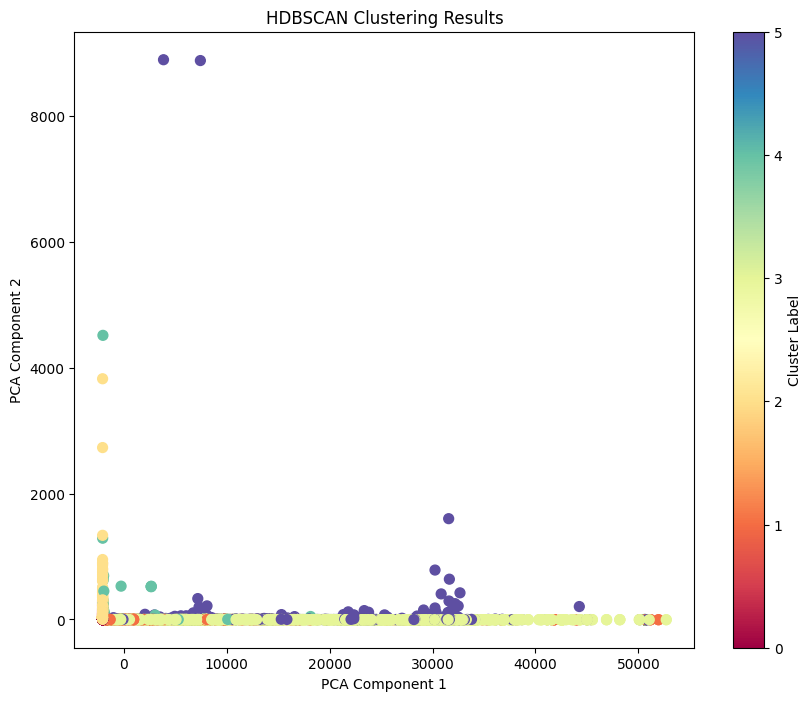

In [17]:
clusterers.visualize()

In [ ]:
labels = clusterers.model.labels_
cluster_5_indices = np.where(labels == 5)[0]
cluster_5 = df_all.iloc[cluster_5_indices]
cluster_5.head()

,author,text,published_at,like_count,source,total_sources,total_comments,screening_time_min,source_entropy
189,user_47358,jak tv ketangkap kejagung karena dibayar utk m...,2025-05-24 20:00:18+00:00,1,debat_tv_one,2,8,33552.183333,0.661563
190,user_47358,karni keliatan memihak penuduh ijazah palsu pa...,2025-05-24 19:58:06+00:00,1,debat_tv_one,2,8,33552.183333,0.661563
193,user_47358,terbukti roy panci narapidana cs mampus di pen...,2025-05-24 19:36:11+00:00,1,debat_tv_one,2,8,33552.183333,0.661563
262,user_41269,saya kira harus di periksa kejiwaan roy suryo cs,2025-05-22 16:06:39+00:00,1,debat_tv_one,2,2,31179.416667,0.693147
298,user_8991,pak suryo memang mantap,2025-05-21 19:24:44+00:00,1,debat_tv_one,2,3,26968.283333,0.636514


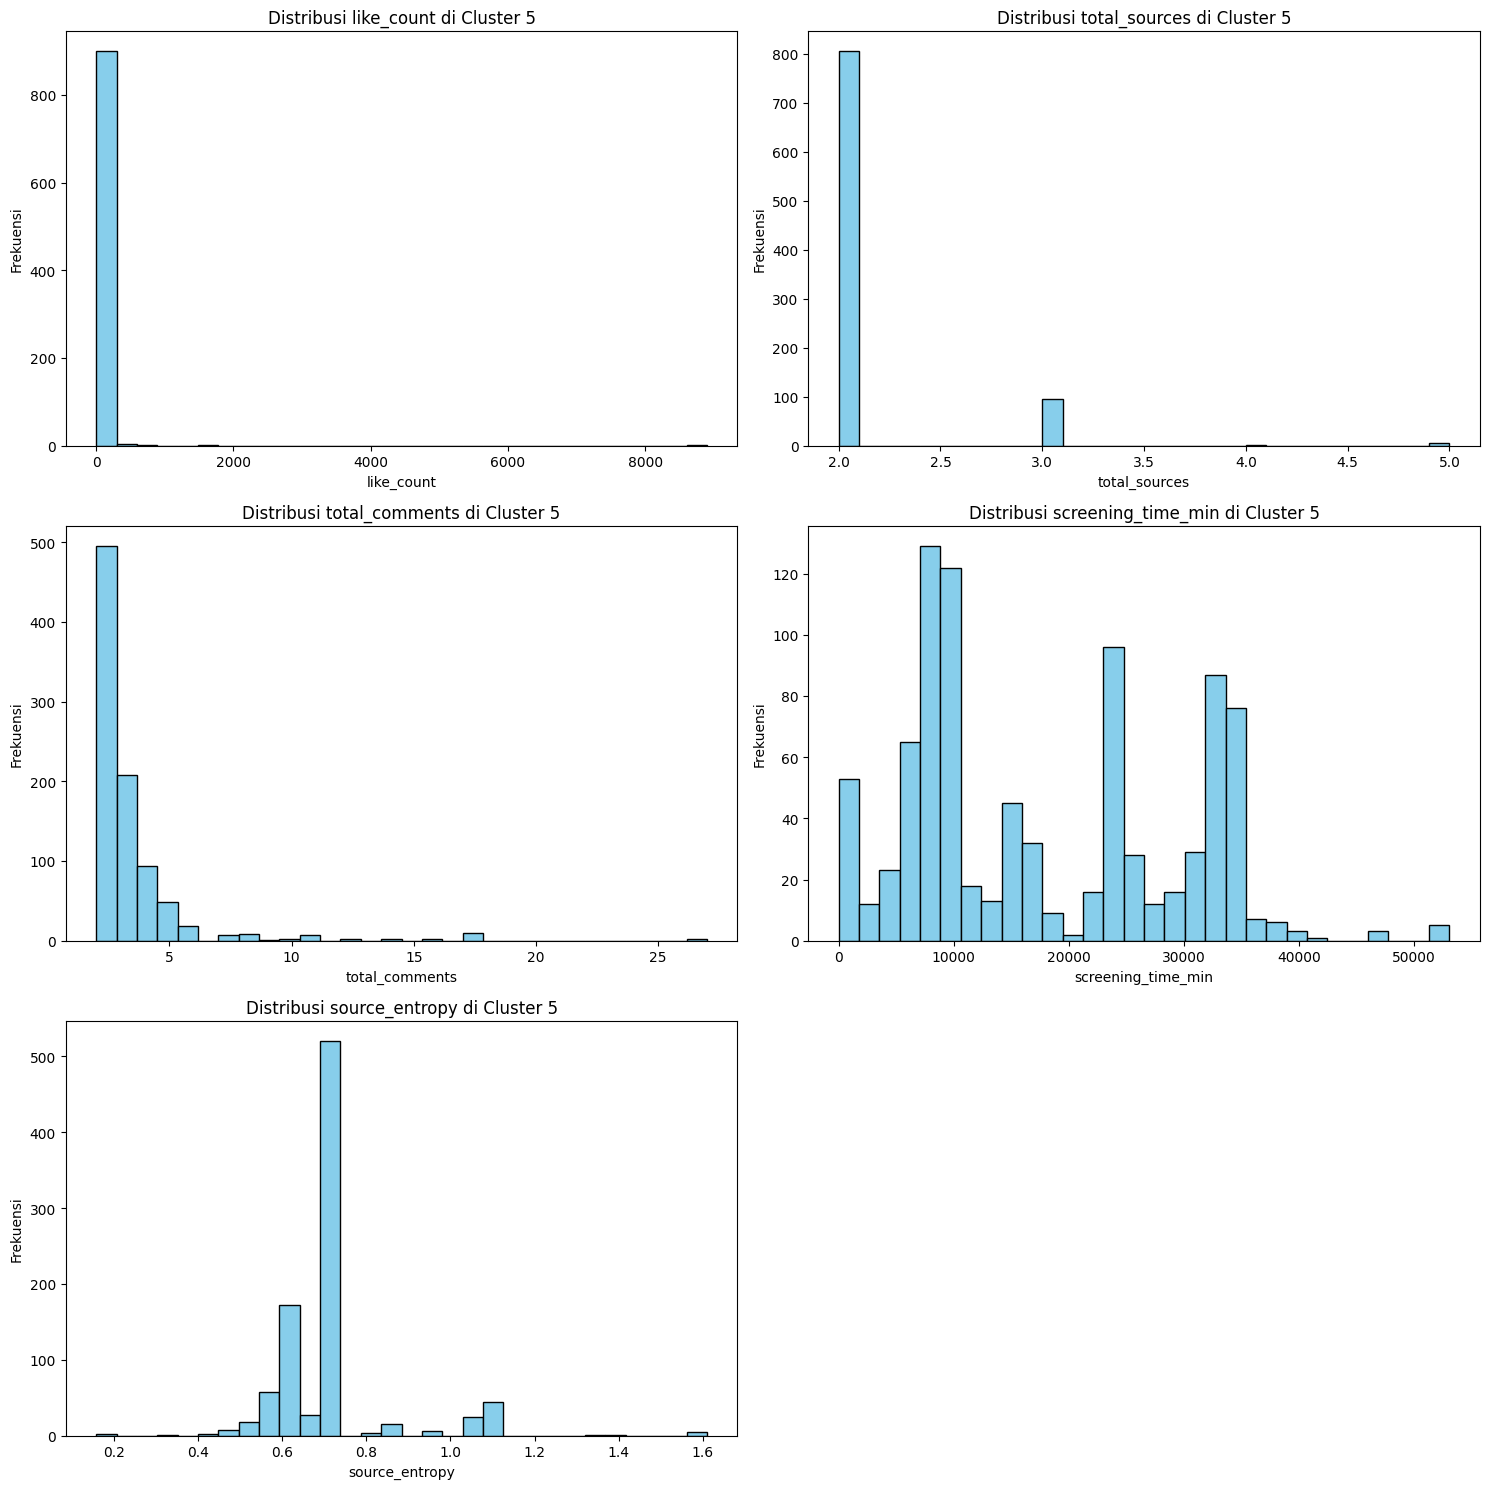

In [ ]:
plot_cluster_hdbcsan(cluster_5)

In [19]:
labels = clusterers.model.labels_
cluster_0_indices = np.where(labels == 0)[0]
cluster_0 = df_all.iloc[cluster_0_indices]

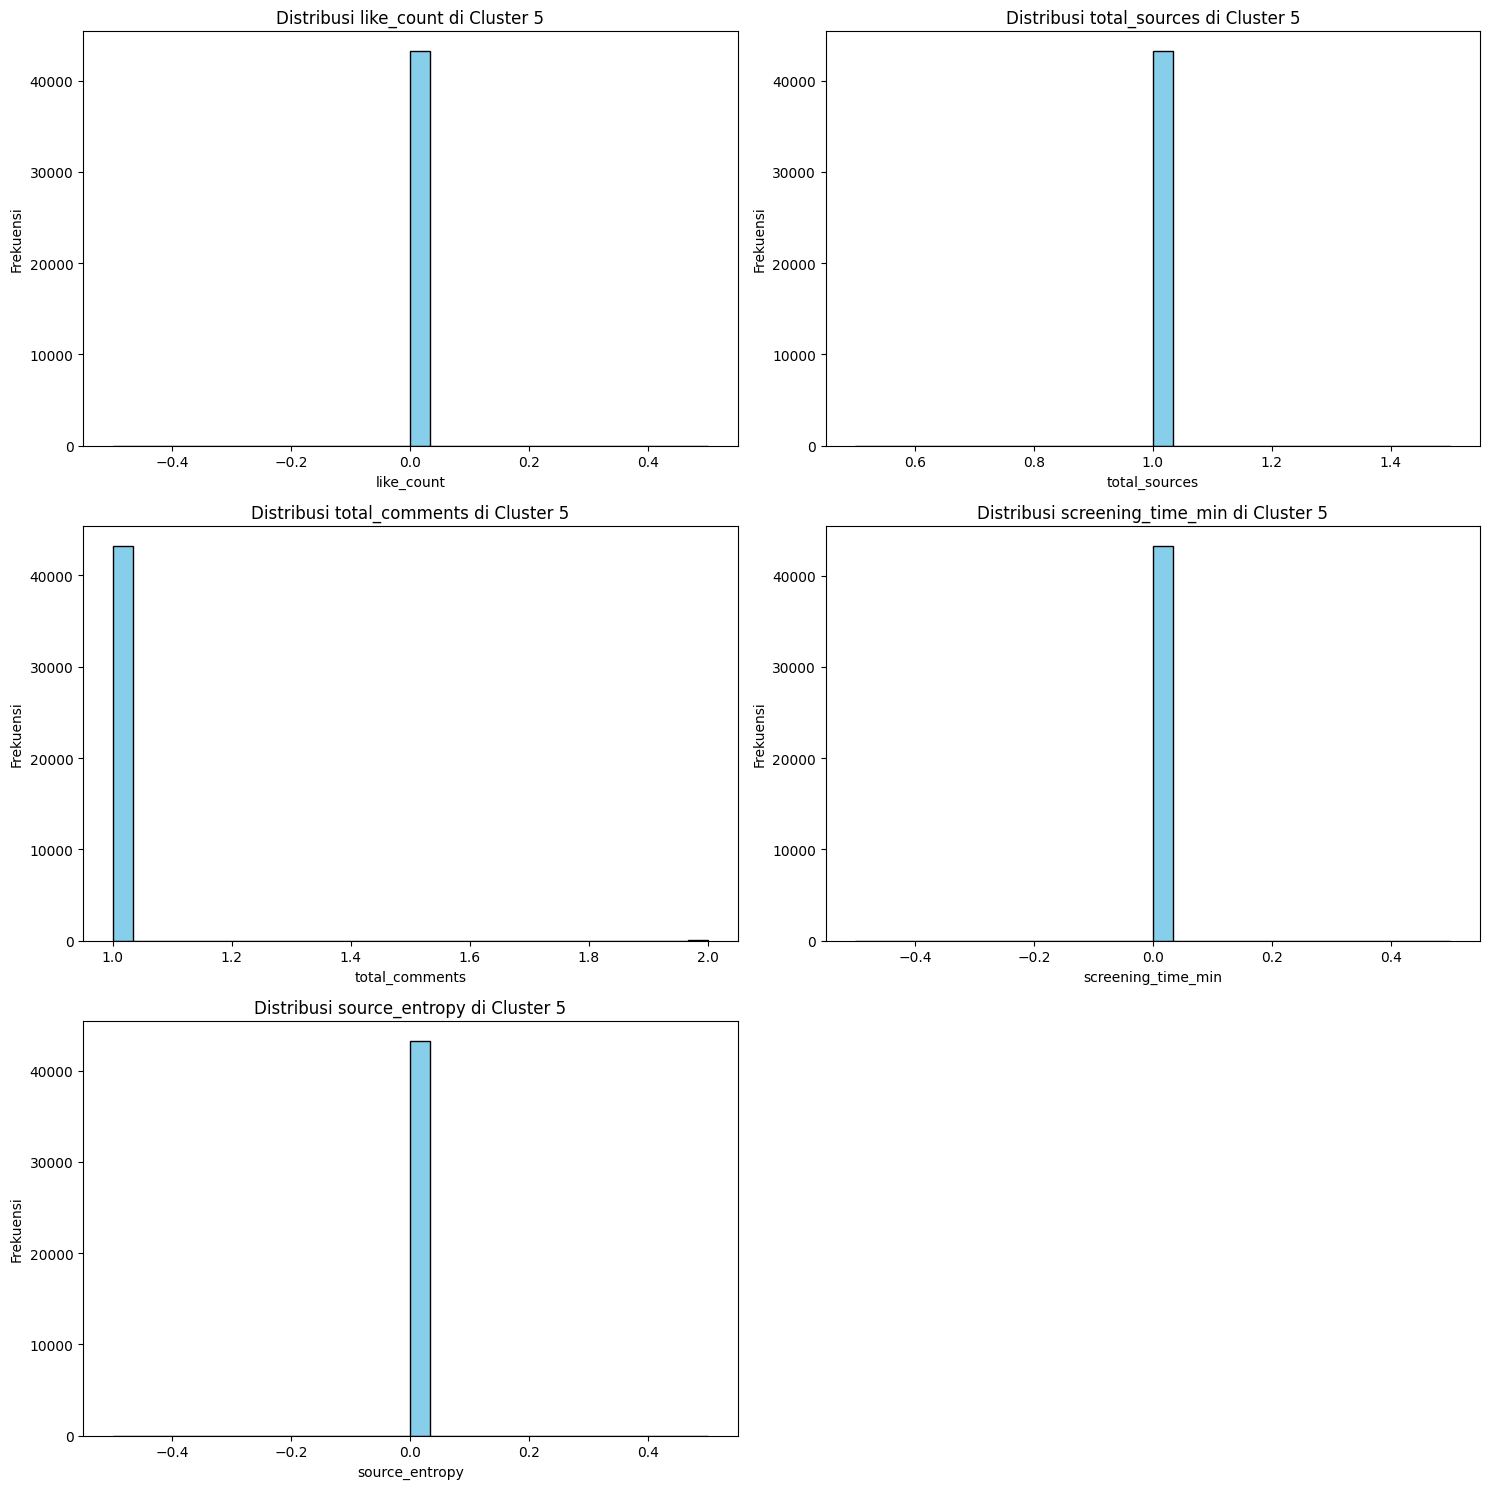

In [20]:
plot_cluster_hdbcsan(cluster_0)

In [23]:
cluster_0.to_csv("cluster_0.csv", index=False)
